# Simulation-based inference with ACE
## Turin task

To run this evaluation notebook, please move the notebook to the outside folder under `amortized-conditioning-engine/`, and please put your trained files under `results/turin` for standard task and `results/turin_pi` for ACE with prior injection.

In [2]:
import sys
import os

import hydra
import matplotlib.pyplot as plt
import matplotlib
import torch
from hydra import initialize, compose
from src.model.base import BaseTransformer
from src.dataset.sampler_joint import Sampler
from src.dataset.sampler_twoway import Sampler as Sampler_base
from src.dataset.sbi.turin import Turin, TurinOnlineAll, TurinOnlineAllSamePrior, TurinOnline

import pickle
import seaborn as sns
import sbi
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from sbi_demo_utils import *
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

update_plot_style()

plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path = "results/turin/"
cfg_twoway, model_twoway = load_config_and_model(path=path, ckpt_name="ckpt_1.tar")

In [4]:
batch_size = 100
dataset = Turin(x_file="data/x_turin_10000.pt",
                theta_file="data/theta_turin_10000.pt",
                order="fixed",
                batch_size=batch_size)

sampler = Sampler_base(problem=dataset, 
                  batch_size=batch_size,
                  num_ctx=101,
                  num_latent=4, 
                  min_num_points=101, 
                  max_num_points=101+1,
                  n_total_points=105,
                  ctx_tar_sampler="predict_latents_fixed")

eval_set = sampler.sample()

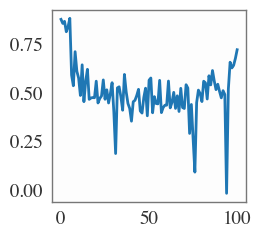

In [5]:
seed = 2
plt.plot(eval_set.xc[seed, :, 1], eval_set.yc[seed, :, 0] )
plt.show()

In [6]:
out_twoway = model_twoway.forward(eval_set, predict=True)
samples_twoway = out_twoway.samples
log_probs_twoway = -out_twoway.losses.sum(dim=-1)
all_log_probs_ace_twoway = log_probs_twoway.mean().detach().numpy()
all_rmse_ace_twoway = RMSE(eval_set.yt, samples_twoway)

In [7]:
print(f"ACE-2 Log probs mean: {all_log_probs_ace_twoway.item()}")
print(f"ACE-2 RMSE mean: {all_rmse_ace_twoway.item()}")

ACE-2 Log probs mean: 3.300541639328003
ACE-2 RMSE mean: 0.23545165359973907


# NPE

In [127]:
x_npe = torch.load("data/x_turin_10000.pt")
theta_npe = torch.load("data/theta_turin_10000.pt")

prior = [Uniform(torch.tensor([0.]), torch.tensor([1.])),
      Uniform(torch.tensor([0.]), torch.tensor([1.])),
      Uniform(torch.tensor([0.]), torch.tensor([1.])),
      Uniform(torch.tensor([0.]), torch.tensor([1.]))]

prior, *_ = process_prior(prior)

posterior_npe = []
for seed in range(5):
    posterior_npe.append(train_npe(prior, theta_npe, x_npe))

posterior_nre = []
for seed in range(5):
    posterior_nre.append(train_nre(prior, theta_npe, x_npe))

# save trained NPE and NRE
save_dir = "data/npe_posteriors_turin"
for i, posterior in enumerate(posterior_npe):
    save_path = os.path.join(save_dir, f"posterior_npe_{i}.pkl")
    with open(save_path, "wb") as handle:
        pickle.dump(posterior, handle)

save_dir = "data/nre_posteriors_turin"
for i, posterior in enumerate(posterior_nre):
    save_path = os.path.join(save_dir, f"posterior_nre_{i}.pkl")
    with open(save_path, "wb") as handle:
        pickle.dump(posterior, handle)

 Neural network successfully converged after 38 epochs.

In [8]:
# load trained NPE and NRE
save_dir = "data/npe_posteriors_turin"
posterior_npe = []
for i in range(5):
    load_path = os.path.join(save_dir, f"posterior_npe_{i}.pkl")
    with open(load_path, "rb") as handle:
        posterior_npe.append(pickle.load(handle))

save_dir = "data/nre_posteriors_turin"
posterior_nre = []
for i in range(5):
    load_path = os.path.join(save_dir, f"posterior_nre_{i}.pkl")
    with open(load_path, "rb") as handle:
        posterior_nre.append(pickle.load(handle))

In [9]:
n_runs = 5
batch_size = 100
dataset = TurinOnlineAll(order="fixed")

num_ctx_for_ppd = 50

# define sampler
sampler_joint = Sampler(problem=dataset, 
                        batch_size=batch_size,
                        num_latent=4, 
                        min_num_points=num_ctx_for_ppd, 
                        max_num_points=num_ctx_for_ppd+1)

eval_set_oneway, eval_set_twoway, eval_set_pi_twoway_narrow, eval_set_pi_twoway_wide = sampler_joint.sample_all_bin()

In [109]:
# save eval sets for posterior inference
data_dir = "data/eval_sets_turin"

torch.save(eval_set_oneway, os.path.join(data_dir, "eval_set_oneway.pt"))
torch.save(eval_set_twoway, os.path.join(data_dir, "eval_set_twoway.pt"))
torch.save(eval_set_pi_twoway_narrow, os.path.join(data_dir, "eval_set_pi_twoway_narrow.pt"))
torch.save(eval_set_pi_twoway_wide, os.path.join(data_dir, "eval_set_pi_twoway_wide.pt"))

In [10]:
# load eval sets for posterior inference
data_dir = "data/eval_sets_turin"

eval_set_oneway = torch.load(os.path.join(data_dir, "eval_set_oneway.pt"))
eval_set_twoway = torch.load(os.path.join(data_dir, "eval_set_twoway.pt"))
eval_set_pi_twoway_narrow = torch.load(os.path.join(data_dir, "eval_set_pi_twoway_narrow.pt"))
eval_set_pi_twoway_wide = torch.load(os.path.join(data_dir, "eval_set_pi_twoway_wide.pt"))

In [11]:
# NPE evaluation
all_log_probs_npe = np.zeros(n_runs)
all_rmse_npe = np.zeros(n_runs)

for seed in range(n_runs):
    
    log_probs_npe = torch.zeros([batch_size])
    for i in range(batch_size):
        log_probs_npe[i] = posterior_npe[seed].log_prob(theta=eval_set_oneway.yt[i].reshape(-1, 4), x=eval_set_oneway.yc[i].reshape(-1, 101))
    all_log_probs_npe[seed] = log_probs_npe.mean().numpy()

    rmse_npe = torch.zeros([batch_size])
    samples_npe_all = torch.empty([batch_size, 4, 100])
    for i in range(batch_size):
        samples_npe_all[i] = posterior_npe[seed].sample((100,), x=eval_set_oneway.yc[i].reshape(-1, 101), show_progress_bars=False).T
    all_rmse_npe[seed] = RMSE(eval_set_oneway.yt, samples_npe_all)

print(f"NPE Log probs mean: {all_log_probs_npe.mean().item()}")
print(f"NPE Log probs std: {all_log_probs_npe.std().item()}")

print(f"NPE RMSE mean: {all_rmse_npe.mean().item()}")
print(f"NPE RMSE std: {all_rmse_npe.std().item()}")

NPE Log probs mean: 1.9912524461746215
NPE Log probs std: 0.04599752717614176
NPE RMSE mean: 0.2596751868724823
NPE RMSE std: 0.0027437677110662595


In [18]:
# NRE evaluation
all_log_probs_nre = np.zeros(n_runs)
all_rmse_nre = np.zeros(n_runs)

for seed in range(n_runs):
    log_probs_nre = torch.zeros([batch_size])
    for i in range(batch_size):
        log_probs_nre[i] = posterior_nre[seed].log_prob(theta=eval_set_oneway.yt[i].reshape(-1, 4), x=eval_set_oneway.yc[i].reshape(-1, 101))
    all_log_probs_nre[seed] = log_probs_nre.mean().numpy()

    rmse_nre = torch.zeros([batch_size])
    samples_nre_all = torch.empty([batch_size, 4, 100])
    for i in range(batch_size):
        samples_nre_all[i] = posterior_nre[seed].sample((100,), x=eval_set_oneway.yc[i].reshape(-1, 101), show_progress_bars=False).T
    all_rmse_nre[seed] = RMSE(eval_set_oneway.yt, samples_nre_all)

print(f"NRE Log probs mean: {all_log_probs_nre.mean().item()}")
print(f"NRE Log probs std: {all_log_probs_nre.std().item()}")

print(f"NRE RMSE mean: {all_rmse_nre.mean().item()}")
print(f"NRE RMSE std: {all_rmse_nre.std().item()}")

NRE Log probs mean: 2.3290260791778565
NRE Log probs std: 0.06666762636256254
NRE RMSE mean: 0.2806220233440399
NRE RMSE std: 0.001313479407788003


## Evaluate ACE posterior inference performance

In [12]:
all_log_probs_ace = np.zeros(5)
all_log_probs_ace_pi_narrow = np.zeros(5)
all_log_probs_ace_pi_wide = np.zeros(5)

all_rmse_ace= np.zeros(5)
all_rmse_ace_pi_narrow = np.zeros(5)
all_rmse_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/turin/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples
    log_probs_twoway = -out_twoway.losses.sum(dim=-1)
    all_log_probs_ace[seed] = log_probs_twoway.mean().detach().numpy()
    all_rmse_ace[seed] = RMSE(eval_set_oneway.yt, samples_twoway)
    
    # two way prior injection narrow
    path = "results/turin_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway_pi_narrow = model_twoway_pi.forward(eval_set_pi_twoway_narrow, predict=True)
    samples_twoway_pi_narrow = out_twoway_pi_narrow.samples
    log_probs_twoway_pi_narrow = -out_twoway_pi_narrow.losses.sum(dim=-1)
    all_log_probs_ace_pi_narrow[seed] = log_probs_twoway_pi_narrow.mean().detach().numpy()
    all_rmse_ace_pi_narrow[seed] = RMSE(eval_set_oneway.yt, samples_twoway_pi_narrow)

    # two way prior injection wide
    out_twoway_pi_wide = model_twoway_pi.forward(eval_set_pi_twoway_wide, predict=True)
    samples_twoway_pi_wide = out_twoway_pi_wide.samples
    log_probs_twoway_pi_wide = -out_twoway_pi_wide.losses.sum(dim=-1)
    all_log_probs_ace_pi_wide[seed] = log_probs_twoway_pi_wide.mean().detach().numpy()
    all_rmse_ace_pi_wide[seed] = RMSE(eval_set_oneway.yt, samples_twoway_pi_wide)

print(f"ACE Log probs mean: {all_log_probs_ace.mean().item()}")
print(f"ACE Log probs std: {all_log_probs_ace.std().item()}")
print(f"ACE RMSE mean: {all_rmse_ace.mean().item()}")
print(f"ACE RMSE std: {all_rmse_ace.std().item()}")

print(f"ACE PI wide Log probs mean: {all_log_probs_ace_pi_wide.mean().item()}")
print(f"ACE PI wide Log probs std: {all_log_probs_ace_pi_wide.std().item()}")
print(f"ACE PI wide RMSE mean: {all_rmse_ace_pi_wide.mean().item()}")
print(f"ACE PI wide RMSE std: {all_rmse_ace_pi_wide.std().item()}")

print(f"ACE PI narrow Log probs mean: {all_log_probs_ace_pi_narrow.mean().item()}")
print(f"ACE PI narrow Log probs std: {all_log_probs_ace_pi_narrow.std().item()}")
print(f"ACE PI narrow RMSE mean: {all_rmse_ace_pi_narrow.mean().item()}")
print(f"ACE PI narrow RMSE std: {all_rmse_ace_pi_narrow.std().item()}")

ACE Log probs mean: 3.14286208152771
ACE Log probs std: 0.020220878142087565
ACE RMSE mean: 0.23716939389705657
ACE RMSE std: 0.0007147010266881706
ACE PI wide Log probs mean: 3.583471727371216
ACE PI wide Log probs std: 0.0382161037715884
ACE PI wide RMSE mean: 0.2082500696182251
ACE PI wide RMSE std: 0.003496872422282558
ACE PI narrow Log probs mean: 4.872329521179199
ACE PI narrow Log probs std: 0.07878937286781737
ACE PI narrow RMSE mean: 0.12779467105865477
ACE PI narrow RMSE std: 0.0028020502271548457


### Ablation - Gaussian head

In [13]:
all_log_probs_ace = np.zeros(5)

all_rmse_ace= np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/turin_gaussian_head/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples.squeeze(-1)
    log_probs_twoway = -out_twoway.losses.sum(dim=-1)
    all_log_probs_ace[seed] = log_probs_twoway.mean().detach().numpy()
    all_rmse_ace[seed] = RMSE(eval_set_oneway.yt, samples_twoway)

print(f"ACE Log probs mean: {all_log_probs_ace.mean().item()}")
print(f"ACE Log probs std: {all_log_probs_ace.std().item()}")
print(f"ACE RMSE mean: {all_rmse_ace.mean().item()}")
print(f"ACE RMSE std: {all_rmse_ace.std().item()}")

ACE Log probs mean: 2.734946775436401
ACE Log probs std: 0.01860418093601749
ACE RMSE mean: 0.23787904977798463
ACE RMSE std: 0.0006054870894587666


# Data prediction

In [14]:
batch_size = 100

eval_set_ppd, eval_set_ppd_pi_narrow, eval_set_ppd_pi_wide = sampler_joint.sample_ppd(sampling_way=3, know_theta=False)

In [121]:
# save eval sets for data prediction
data_dir = "data/eval_sets_ppd_turin"

torch.save(eval_set_ppd, os.path.join(data_dir, "eval_set_ppd.pt"))
torch.save(eval_set_ppd_pi_narrow, os.path.join(data_dir, "eval_set_ppd_pi_narrow.pt"))
torch.save(eval_set_ppd_pi_wide, os.path.join(data_dir, "eval_set_ppd_pi_wide.pt"))

In [15]:
# load eval sets for posterior inference
data_dir = "data/eval_sets_ppd_turin"

eval_set_ppd = torch.load(os.path.join(data_dir, "eval_set_ppd.pt"))
eval_set_ppd_pi_narrow = torch.load(os.path.join(data_dir, "eval_set_ppd_pi_narrow.pt"))
eval_set_ppd_pi_wide = torch.load(os.path.join(data_dir, "eval_set_ppd_pi_wide.pt"))

In [120]:
all_mmd_ppd_ace = np.zeros(5)
all_mmd_ppd_ace_pi_narrow = np.zeros(5)
all_mmd_ppd_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/turin/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
    samples_ppd_twoway = out_ppd_twoway.samples
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_ppd_twoway[i].T, eval_set_ppd.yt[i].T, lengthscale=1))
    all_mmd_ppd_ace[seed] = mmd / batch_size

    # two way prior injection narrow
    path = "results/turin_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway_pi_narrow = model_twoway_pi.forward(eval_set_ppd_pi_narrow, predict=True)
    samples_ppd_pi_twoway_narrow = out_ppd_twoway_pi_narrow.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_ppd_pi_twoway_narrow[i, :, :].T, eval_set_ppd_pi_narrow.yt[i, :, :].T, lengthscale=1))
    all_mmd_ppd_ace_pi_narrow[seed] = mmd / batch_size

    # two way prior injection wide
    out_ppd_twoway_pi_wide = model_twoway_pi.forward(eval_set_ppd_pi_wide, predict=True)
    samples_ppd_pi_twoway_wide = out_ppd_twoway_pi_wide.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_ppd_pi_twoway_wide[i, :, :].T, eval_set_ppd_pi_wide.yt[i, :, :].T, lengthscale=1))
    all_mmd_ppd_ace_pi_wide[seed] = mmd / batch_size

print(f"ACE-2 PPD MMD mean: {all_mmd_ppd_ace.mean().item()}")
print(f"ACE-2 PPD MMD std: {all_mmd_ppd_ace.std().item()}")

print(f"ACE-2 PPD PI wide MMD mean: {all_mmd_ppd_ace_pi_wide.mean().item()}")
print(f"ACE-2 PPD PI wide MMD std: {all_mmd_ppd_ace_pi_wide.std().item()}")

print(f"ACE-2 PPD PI narrow MMD mean: {all_mmd_ppd_ace_pi_narrow.mean().item()}")
print(f"ACE-2 PPD PI narrow MMD std: {all_mmd_ppd_ace_pi_narrow.std().item()}")

ACE-2 PPD MMD mean: 0.3450903770923615
ACE-2 PPD MMD std: 0.00028470618630375814
ACE-2 PPD PI wide MMD mean: 0.3454768614768982
ACE-2 PPD PI wide MMD std: 0.00029789210231647274
ACE-2 PPD PI narrow MMD mean: 0.3355480173826218
ACE-2 PPD PI narrow MMD std: 0.0006234225656566184


In [48]:
# Gaussian head
all_mmd_ppd_ace = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/turin_gaussian_head/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
    samples_ppd_twoway = out_ppd_twoway.samples.squeeze(-1)
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_ppd_twoway[i].T, eval_set_ppd.yt[i].T, lengthscale=1))
    all_mmd_ppd_ace[seed] = mmd / batch_size


print(f"ACE-2 PPD MMD mean: {all_mmd_ppd_ace.mean().item()}")
print(f"ACE-2 PPD MMD std: {all_mmd_ppd_ace.std().item()}")


ACE-2 PPD MMD mean: 0.35560846686363223
ACE-2 PPD MMD std: 0.0007161916404605061


In [122]:
torch.save(all_log_probs_npe, "results/metrics/turin_log_probs_npe.npy")
torch.save(all_log_probs_nre, "results/metrics/turin_log_probs_nre.npy")
torch.save(all_log_probs_ace, "results/metrics/turin_log_probs_ace.npy")
torch.save(all_log_probs_ace_pi_narrow, "results/metrics/turin_log_probs_ace_narrow.npy")
torch.save(all_log_probs_ace_pi_wide, "results/metrics/turin_log_probs_ace_wide.npy")

torch.save(all_rmse_npe, "results/metrics/turin_rmse_npe.npy")
torch.save(all_rmse_nre, "results/metrics/turin_rmse_nre.npy")
torch.save(all_rmse_ace, "results/metrics/turin_rmse_ace.npy")
torch.save(all_rmse_ace_pi_narrow, "results/metrics/turin_rmse_ace_narrow.npy")
torch.save(all_rmse_ace_pi_wide, "results/metrics/turin_rmse_ace_wide.npy")

torch.save(all_mmd_ppd_ace, "results/metrics/turin_mmd_ace.npy")
torch.save(all_mmd_ppd_ace_pi_narrow, "results/metrics/turin_mmd_ace_narrow.npy")
torch.save(all_mmd_ppd_ace_pi_wide, "results/metrics/turin_mmd_ace_wide.npy")

In [9]:
all_log_probs_npe = torch.load("results/metrics/turin_log_probs_npe.npy")
all_log_probs_nre = torch.load("results/metrics/turin_log_probs_nre.npy")
all_log_probs_ace = torch.load("results/metrics/turin_log_probs_ace.npy")
all_log_probs_ace_pi_narrow = torch.load("results/metrics/turin_log_probs_ace_narrow.npy")
all_log_probs_ace_pi_wide = torch.load("results/metrics/turin_log_probs_ace_wide.npy")

all_rmse_npe = torch.load("results/metrics/turin_rmse_npe.npy")
all_rmse_nre = torch.load("results/metrics/turin_rmse_nre.npy")
all_rmse_ace = torch.load("results/metrics/turin_rmse_ace.npy")
all_rmse_ace_pi_narrow = torch.load("results/metrics/turin_rmse_ace_narrow.npy")
all_rmse_ace_pi_wide = torch.load("results/metrics/turin_rmse_ace_wide.npy")

all_mmd_ppd_ace = torch.load("results/metrics/turin_mmd_ace.npy")
all_mmd_ppd_ace_pi_narrow = torch.load("results/metrics/turin_mmd_ace_narrow.npy")
all_mmd_ppd_ace_pi_wide = torch.load("results/metrics/turin_mmd_ace_wide.npy")


# Simulation-based calibration

In [3]:
def plot_sbc_rank_histogram(theta_prior, theta_posterior, num_bins=None):
    """
    Plot the rank statistic histogram for Simulation-Based Calibration (SBC).

    Args:
    - theta_prior: torch.Tensor, shape [num_samples, 1], samples drawn from the prior distribution.
    - theta_posterior: torch.Tensor, shape [num_samples, num_posterior_samples], posterior samples for each theta_prior.
    - num_bins: int, optional, the number of bins for the histogram (default is num_posterior_samples + 1).
    """
    num_samples, num_posterior_samples = theta_posterior.shape

    # Expand theta_prior to match the shape of theta_posterior
    theta_prior_expanded = theta_prior.expand(-1, num_posterior_samples)

    # Calculate the rank of each theta_prior in the corresponding posterior samples
    less_than = (theta_posterior < theta_prior_expanded).long()

    ranks = torch.sum(less_than, dim=1)

    # Set the number of bins for the histogram
    if num_bins is None:
        num_bins = num_posterior_samples + 1  # Possible rank values range from 0 to num_posterior_samples

    # Convert ranks to numpy for histogram calculation
    ranks_np = ranks.numpy()

    # Calculate histogram counts and bin edges using numpy
    counts, bin_edges = np.histogram(ranks_np, bins=num_bins, range=(0, num_posterior_samples))
    counts = counts.astype(float) / num_samples  # Normalize the counts to get frequency

    # Create the histogram plot
    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], counts, width=1, edgecolor='black', align='edge')

    # Add a uniform distribution reference line
    uniform_height = 1.0 / num_bins
    plt.axhline(y=uniform_height, color='red', linestyle='--', label=f'Uniform distribution ({uniform_height:.2f})')

    # Add labels and title
    plt.xlabel('Rank statistics')
    plt.ylabel('Frequency')
    plt.title('SBC Rank Histogram')
    # plt.xticks(range(0, num_posterior_samples + 1))
    # plt.legend()

    # Show the plot
    plt.show()

In [4]:
from scipy import stats

def get_coverage_probs(z, u):
    """Vectorized function to compute the minimal coverage probability for uniform ECDFs given evaluation points z and a sample of samples u."""
    N = u.shape[1]
    F_m = np.sum((z[:, np.newaxis] >= u[:, np.newaxis, :]), axis=-1) / u.shape[1]
    bin1 = stats.binom(N, z).cdf(N * F_m)
    bin2 = stats.binom(N, z).cdf(N * F_m - 1)
    gamma = 2 * np.min(np.min(np.stack([bin1, 1 - bin2], axis=-1), axis=-1), axis=-1)
    return gamma

def simultaneous_ecdf_bands(num_samples, num_points=None, num_simulations=1000, confidence=0.95, eps=1e-5, max_num_points=1000):
    """Computes the simultaneous ECDF bands through simulation according to the algorithm described."""
    N = num_samples
    if num_points is None:
        K = min(N, max_num_points)
    else:
        K = min(num_points, max_num_points)
    M = num_simulations

    z = np.linspace(0 + eps, 1 - eps, K)
    u = np.random.uniform(size=(M, N))

    alpha = 1 - confidence
    gammas = get_coverage_probs(z, u)

    gamma = np.percentile(gammas, 100 * alpha)
    L = stats.binom(N, z).ppf(gamma / 2) / N
    U = stats.binom(N, z).ppf(1 - gamma / 2) / N
    return alpha, z, L, U

def plot_sbc_ecdf_diff(ax, theta_prior, theta_posterior, theta_posterior_pi, num_points=20):
    """
    Plot the ECDF difference for Simulation-Based Calibration (SBC).

    Args:
    - theta_prior: torch.Tensor, shape [num_samples, 1], samples drawn from the prior distribution.
    - theta_posterior: torch.Tensor, shape [num_samples, num_posterior_samples], posterior samples for each theta_prior.
    - num_points: int, optional, the number of points along the x-axis to control precision (default is 20).
    """
    num_samples, num_posterior_samples = theta_posterior.shape

    # Expand theta_prior to match the shape of theta_posterior
    theta_prior_expanded = theta_prior.expand(-1, num_posterior_samples)

    # Calculate the rank of each theta_prior in the corresponding posterior samples
    less_than = (theta_posterior < theta_prior_expanded).long()
    ranks = torch.sum(less_than, dim=1)

    less_than_pi = (theta_posterior_pi < theta_prior_expanded).long()
    ranks_pi = torch.sum(less_than_pi, dim=1)

    # Calculate the fractional rank (normalize ranks by num_posterior_samples)
    fractional_ranks = ranks.float() / num_posterior_samples
    fractional_ranks_pi = ranks_pi.float() / num_posterior_samples

    # Calculate the ECDF of the fractional ranks
    sorted_ranks = torch.sort(fractional_ranks)[0].numpy()
    sorted_ranks_pi = torch.sort(fractional_ranks_pi)[0].numpy()
    ecdf = np.arange(1, num_samples + 1) / num_samples

    # Calculate the difference between ECDF and the uniform distribution
    uniform_cdf = sorted_ranks  # In uniform distribution, CDF is the same as the rank values
    uniform_cdf_pi = sorted_ranks_pi
    ecdf_diff = ecdf - uniform_cdf
    ecdf_diff_pi = ecdf - uniform_cdf_pi

    # Generate points for the x-axis (fractional rank statistics)
    x_points = np.linspace(0, 1, num_points)

    # Interpolate ECDF difference for these x_points
    ecdf_diff_interpolated = np.interp(x_points, sorted_ranks, ecdf_diff)
    ecdf_diff_interpolated_pi = np.interp(x_points, sorted_ranks_pi, ecdf_diff_pi)

    _, z, L, U = simultaneous_ecdf_bands(num_samples=num_samples, num_points=num_points, num_simulations=1000, confidence=0.95)

    L -= z
    U -= z

    # Plot the ECDF difference curve
    ax.plot(x_points, ecdf_diff_interpolated, color='purple', label='ACE', linewidth=3)
    ax.plot(x_points, ecdf_diff_interpolated_pi, color='green', label='ACEP', linewidth=3)
    ax.set_ylim(-0.12, 0.12)

    # ax.fill_between(z, L, U, color='gray', alpha=0.3, label=f'{int(0.95 * 100)}% Confidence Bands')
    ax.fill_between(z, L, U, color='gray', alpha=0.3)
    # Add a shaded area to represent the 95% confidence band
    # confidence_band = 1.36 / np.sqrt(num_samples)  # DKW bound for confidence band
    # confidence_band_shape = confidence_band * np.sqrt(x_points * (1 - x_points))  # Circular band
    # plt.fill_between(x_points, -confidence_band_shape, confidence_band_shape, color='gray', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Fractional Rank', fontsize=18)


In [5]:
seed = 1

path = "results/turin/"
cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")

path = "results/turin_pi/"
cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")

In [702]:
batch_size = 500
dataset = TurinOnlineAllSamePrior(order="fixed")

num_ctx_for_ppd = 50

# define sampler
sampler_joint = Sampler(problem=dataset, 
                        batch_size=batch_size,
                        num_latent=4, 
                        min_num_points=num_ctx_for_ppd, 
                        max_num_points=num_ctx_for_ppd+1)

eval_set_oneway, eval_set_twoway, eval_set_pi_twoway_narrow, eval_set_pi_twoway_wide = sampler_joint.sample_all_bin()

In [572]:
out_twoway = model_twoway.forward(eval_set_twoway, predict=True, num_samples=100)
ace_posterior_samples = out_twoway.samples
prior_samples = eval_set_twoway.yt.squeeze(-1)

out_twoway_pi = model_twoway_pi.forward(eval_set_pi_twoway_narrow, predict=True, num_samples=100)
ace_posterior_samples_pi = out_twoway_pi.samples
prior_samples = eval_set_twoway.yt.squeeze(-1)

In [6]:
def calculate_average_deviation(theta_prior, theta_posterior, num_points=20, num_simulations=1000, confidence=0.95):
    """
    Calculate the average absolute deviation for Simulation-Based Calibration (SBC).
    
    Args:
    - theta_prior: torch.Tensor, shape [num_samples, num_latent], samples drawn from the prior distribution.
    - theta_posterior: torch.Tensor, shape [num_samples, num_latent, num_posterior_samples], posterior samples for each theta_prior.
    - num_points: int, optional, the number of points along the x-axis to control precision (default is 20).
    - num_simulations: int, optional, the number of simulations for computing confidence bands (default is 1000).
    - confidence: float, optional, the confidence level for the bands (default is 0.95).
    
    Returns:
    - average_deviation: float, the average absolute deviation across all latent variables.
    """
    num_samples, num_latent, num_posterior_samples = theta_posterior.shape
    total_deviation = 0

    # Loop over each latent variable and calculate the deviation
    for latent_idx in range(num_latent):
        # Expand theta_prior for the current latent variable to match the shape of theta_posterior
        theta_prior_expanded = theta_prior[:, latent_idx].unsqueeze(-1).expand(-1, num_posterior_samples)

        # Calculate the rank of each theta_prior in the corresponding posterior samples
        less_than = (theta_posterior[:, latent_idx, :] < theta_prior_expanded).long()
        ranks = torch.sum(less_than, dim=1)

        # Calculate the fractional rank (normalize ranks by num_posterior_samples)
        fractional_ranks = ranks.float() / num_posterior_samples

        # Calculate the ECDF of the fractional ranks
        sorted_ranks = torch.sort(fractional_ranks)[0].numpy()
        ecdf = np.arange(1, num_samples + 1) / num_samples

        # Calculate the difference between ECDF and the uniform distribution
        uniform_cdf = sorted_ranks  # In uniform distribution, CDF is the same as the rank values
        ecdf_diff = ecdf - uniform_cdf

        # Generate points for the x-axis (fractional rank statistics)
        x_points = np.linspace(0, 1, num_points)

        # Interpolate ECDF difference for these x_points
        ecdf_diff_interpolated = np.interp(x_points, sorted_ranks, ecdf_diff)

        # Calculate the average absolute deviation for the current latent variable
        total_deviation += np.mean(np.abs(ecdf_diff_interpolated))

    # Average the deviation over all latent variables
    average_deviation = total_deviation / num_latent

    return average_deviation



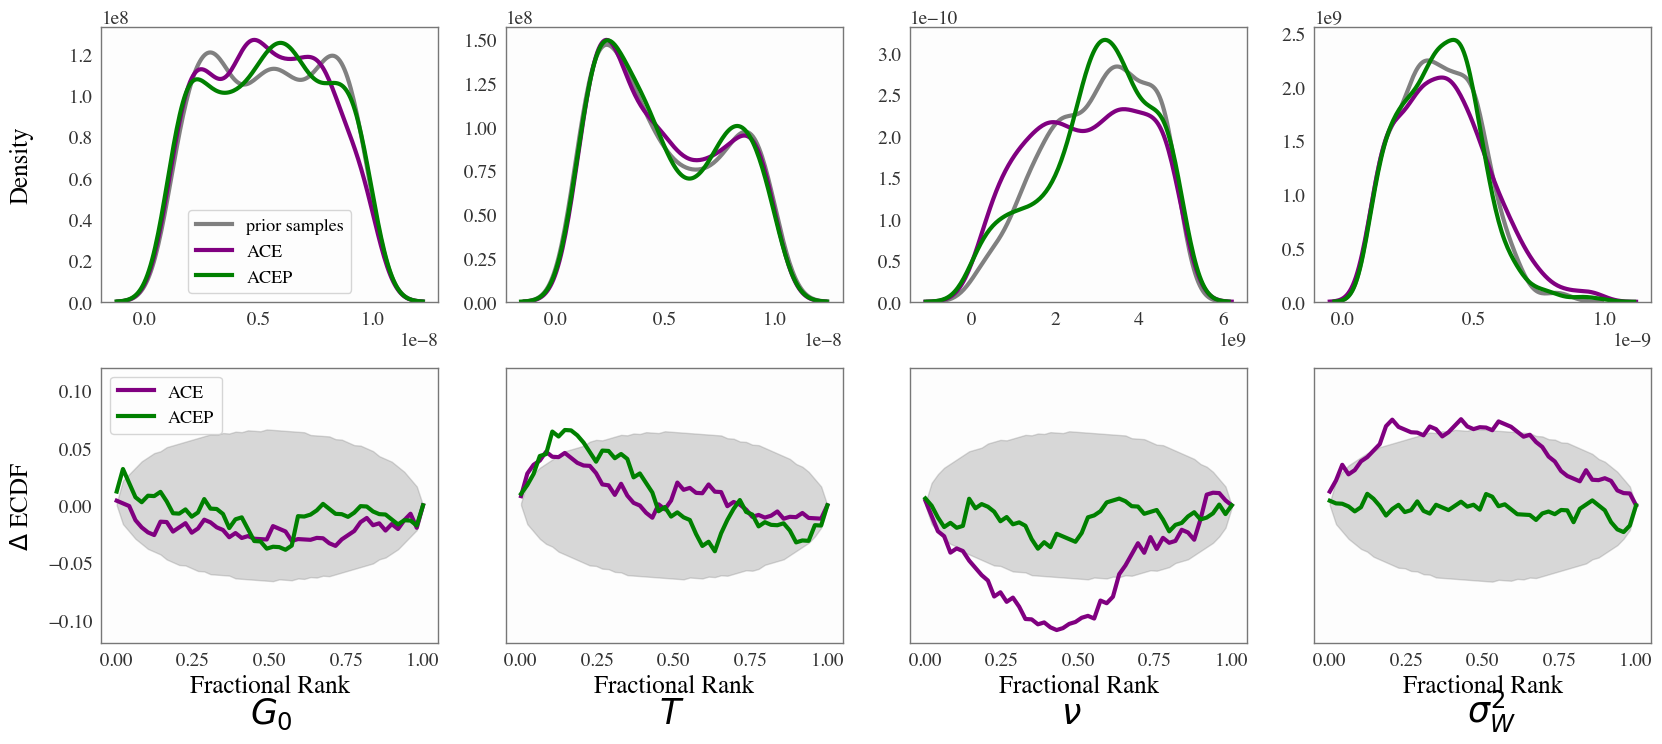

In [7]:
prior_samples = torch.load("data/sbc_prior_samples.pt")
ace_posterior_samples = torch.load("data/sbc_posterior_samples.pt")
ace_posterior_samples_pi = torch.load("data/sbc_posterior_samples_pi.pt")

ace_posterior_samples_1 = ace_posterior_samples[:, 0, 1] * (1e-8-1e-9) + 1e-9
ace_posterior_samples_pi_1 = ace_posterior_samples_pi[:, 0, 1] * (1e-8-1e-9) + 1e-9
prior_samples_1 = prior_samples[:, 0] * (1e-8-1e-9) + 1e-9
ace_posterior_samples_2 = ace_posterior_samples[:, 1, 1] * (1e-8-1e-9) + 1e-9
ace_posterior_samples_pi_2 = ace_posterior_samples_pi[:, 1, 1] * (1e-8-1e-9) + 1e-9
prior_samples_2 = prior_samples[:, 1] * (1e-8-1e-9) + 1e-9
ace_posterior_samples_3 = ace_posterior_samples[:, 2, 1] * (5e9-1e7) + 1e7
ace_posterior_samples_pi_3 = ace_posterior_samples_pi[:, 2, 1] * (5e9-1e7) + 1e7
prior_samples_3 = prior_samples[:, 2] * (5e9-1e7) + 1e7
ace_posterior_samples_4 = ace_posterior_samples[:, 3, 1] * (1e-9-1e-10) + 1e-10
ace_posterior_samples_pi_4 = ace_posterior_samples_pi[:, 3, 1] * (1e-9-1e-10) + 1e-10
prior_samples_4 = prior_samples[:, 3] * (1e-9-1e-10) + 1e-10

fig, axs = plt.subplots(2, 4, figsize=(20, 8))

sns.kdeplot(prior_samples_1, color="grey", linewidth=3, linestyle="solid", label="prior samples", ax=axs[0, 0])
sns.kdeplot(ace_posterior_samples_1, color="purple", linewidth=3, linestyle="solid", label="ACE", ax=axs[0, 0])
sns.kdeplot(ace_posterior_samples_pi_1, color="green", linewidth=3, linestyle="solid", label="ACEP", ax=axs[0, 0])
axs[0, 0].set_ylabel("Density", fontsize=18)
# axs[0, 0].set_xlabel("$x$", fontsize=18)
axs[0, 0].legend(fontsize=13, loc=8)
axs[0, 0].yaxis.set_label_coords(-0.2, 0.5)

sns.kdeplot(prior_samples_2, color="grey", linewidth=3, linestyle="solid", label="prior", ax=axs[0, 1])
sns.kdeplot(ace_posterior_samples_2, color="purple", linewidth=3, linestyle="solid", label="ACE", ax=axs[0, 1])
sns.kdeplot(ace_posterior_samples_pi_2, color="green", linewidth=3, linestyle="solid", label="ACEP", ax=axs[0, 1])
# axs[0, 1].set_xlabel("$x$", fontsize=18)
axs[0, 1].set_ylabel("")

sns.kdeplot(prior_samples_3, color="grey", linewidth=3, linestyle="solid", label="prior", ax=axs[0, 2])
sns.kdeplot(ace_posterior_samples_3, color="purple", linewidth=3, linestyle="solid", label="ACE", ax=axs[0, 2])
sns.kdeplot(ace_posterior_samples_pi_3, color="green", linewidth=3, linestyle="solid", label="ACEP", ax=axs[0, 2])
# axs[0, 2].set_xlim(-0.2, 1.2)
axs[0, 2].set_ylabel("")
# axs[0, 2].set_xlabel("$x$", fontsize=18)

sns.kdeplot(prior_samples_4, color="grey", linewidth=3, linestyle="solid", label="prior", ax=axs[0, 3])
sns.kdeplot(ace_posterior_samples_4, color="purple", linewidth=3, linestyle="solid", label="ACE", ax=axs[0, 3])
sns.kdeplot(ace_posterior_samples_pi_4, color="green", linewidth=3, linestyle="solid", label="ACEP", ax=axs[0, 3])
# axs[0, 3].set_xlabel("$x$", fontsize=18)
axs[0, 3].set_ylabel("")

# fig.suptitle("ECDF Difference vs Fractional Rank Statistic")
plot_sbc_ecdf_diff(axs[1, 0], prior_samples[:, 0].unsqueeze(-1), ace_posterior_samples[:, 0, :], ace_posterior_samples_pi[:, 0, :], num_points=50)
axs[1, 0].set_ylabel(r'$\Delta$ ECDF', fontsize=18)
axs[1, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[1, 0].legend(fontsize=13, loc=2)

plot_sbc_ecdf_diff(axs[1,1], prior_samples[:, 1].unsqueeze(-1), ace_posterior_samples[:, 1, :], ace_posterior_samples_pi[:, 1, :], num_points=50)
axs[1, 1].set_yticks([])
plot_sbc_ecdf_diff(axs[1,2], prior_samples[:, 2].unsqueeze(-1), ace_posterior_samples[:, 2, :], ace_posterior_samples_pi[:, 2, :], num_points=50)
axs[1, 2].set_yticks([])
plot_sbc_ecdf_diff(axs[1,3], prior_samples[:, 3].unsqueeze(-1), ace_posterior_samples[:, 3, :], ace_posterior_samples_pi[:, 3, :], num_points=50)
axs[1, 3].set_yticks([])

fig.text(0.21, 0.01, '$G_0$', ha='center', fontsize=25)
fig.text(0.41, 0.01, '$T$', ha='center', fontsize=25)
fig.text(0.61, 0.01, '$\\nu$', ha='center', fontsize=25)
fig.text(0.82, 0.011, '$\sigma^2_W$', ha='center', fontsize=25)
# plt.tight_layout()
plt.subplots_adjust(hspace=0.24)
plt.savefig("sbc_pi.pdf")
plt.show()

In [653]:
torch.save(prior_samples, "data/sbc_prior_samples.pt")
torch.save(ace_posterior_samples, "data/sbc_posterior_samples.pt")
torch.save(ace_posterior_samples_pi, "data/sbc_posterior_samples_pi.pt")

# Only ACE

In [693]:
from scipy import stats

def get_coverage_probs(z, u):
    """Vectorized function to compute the minimal coverage probability for uniform ECDFs given evaluation points z and a sample of samples u."""
    N = u.shape[1]
    F_m = np.sum((z[:, np.newaxis] >= u[:, np.newaxis, :]), axis=-1) / u.shape[1]
    bin1 = stats.binom(N, z).cdf(N * F_m)
    bin2 = stats.binom(N, z).cdf(N * F_m - 1)
    gamma = 2 * np.min(np.min(np.stack([bin1, 1 - bin2], axis=-1), axis=-1), axis=-1)
    return gamma

def simultaneous_ecdf_bands(num_samples, num_points=None, num_simulations=1000, confidence=0.95, eps=1e-5, max_num_points=1000):
    """Computes the simultaneous ECDF bands through simulation according to the algorithm described."""
    N = num_samples
    if num_points is None:
        K = min(N, max_num_points)
    else:
        K = min(num_points, max_num_points)
    M = num_simulations

    z = np.linspace(0 + eps, 1 - eps, K)
    u = np.random.uniform(size=(M, N))

    alpha = 1 - confidence
    gammas = get_coverage_probs(z, u)

    gamma = np.percentile(gammas, 100 * alpha)
    L = stats.binom(N, z).ppf(gamma / 2) / N
    U = stats.binom(N, z).ppf(1 - gamma / 2) / N
    return alpha, z, L, U

def plot_sbc_ecdf_diff_no_pi(ax, theta_prior, theta_posterior, num_points=20):
    """
    Plot the ECDF difference for Simulation-Based Calibration (SBC).

    Args:
    - theta_prior: torch.Tensor, shape [num_samples, 1], samples drawn from the prior distribution.
    - theta_posterior: torch.Tensor, shape [num_samples, num_posterior_samples], posterior samples for each theta_prior.
    - num_points: int, optional, the number of points along the x-axis to control precision (default is 20).
    """
    num_samples, num_posterior_samples = theta_posterior.shape

    # Expand theta_prior to match the shape of theta_posterior
    theta_prior_expanded = theta_prior.expand(-1, num_posterior_samples)

    # Calculate the rank of each theta_prior in the corresponding posterior samples
    less_than = (theta_posterior < theta_prior_expanded).long()
    ranks = torch.sum(less_than, dim=1)


    # Calculate the fractional rank (normalize ranks by num_posterior_samples)
    fractional_ranks = ranks.float() / num_posterior_samples

    # Calculate the ECDF of the fractional ranks
    sorted_ranks = torch.sort(fractional_ranks)[0].numpy()
    ecdf = np.arange(1, num_samples + 1) / num_samples

    # Calculate the difference between ECDF and the uniform distribution
    uniform_cdf = sorted_ranks  # In uniform distribution, CDF is the same as the rank values

    ecdf_diff = ecdf - uniform_cdf

    # Generate points for the x-axis (fractional rank statistics)
    x_points = np.linspace(0, 1, num_points)

    # Interpolate ECDF difference for these x_points
    ecdf_diff_interpolated = np.interp(x_points, sorted_ranks, ecdf_diff)

    _, z, L, U = simultaneous_ecdf_bands(num_samples=num_samples, num_points=num_points, num_simulations=1000, confidence=0.95)

    L -= z
    U -= z

    # Plot the ECDF difference curve
    ax.plot(x_points, ecdf_diff_interpolated, color='purple', label='ACE', linewidth=3)
    ax.set_ylim(-0.07, 0.07)

    # ax.fill_between(z, L, U, color='gray', alpha=0.3, label=f'{int(0.95 * 100)}% Confidence Bands')
    ax.fill_between(z, L, U, color='gray', alpha=0.3)
    # Add a shaded area to represent the 95% confidence band
    # confidence_band = 1.36 / np.sqrt(num_samples)  # DKW bound for confidence band
    # confidence_band_shape = confidence_band * np.sqrt(x_points * (1 - x_points))  # Circular band
    # plt.fill_between(x_points, -confidence_band_shape, confidence_band_shape, color='gray', alpha=0.3)

    # Add labels and title
    ax.set_xlabel('Fractional Rank', fontsize=18)


In [731]:
batch_size = 1000
dataset = TurinOnline(order="fixed")

num_ctx_for_ppd = 50

# define sampler
sampler_base = Sampler_base(problem=dataset, 
                        num_ctx=101,
                        batch_size=batch_size,
                        num_latent=4, 
                        min_num_points=num_ctx_for_ppd, 
                        max_num_points=num_ctx_for_ppd+1,
                        ctx_tar_sampler="predict_latents_fixed")

eval_set = sampler_base.sample()

In [732]:
out_twoway = model_twoway.forward(eval_set, predict=True, num_samples=100)
ace_posterior_samples = out_twoway.samples
prior_samples = eval_set.yt.squeeze(-1)

In [734]:
ace_posterior_samples_1 = ace_posterior_samples[:, 0, 1] * (1e-8-1e-9) + 1e-9
prior_samples_1 = prior_samples[:, 0] * (1e-8-1e-9) + 1e-9
ace_posterior_samples_2 = ace_posterior_samples[:, 1, 1] * (1e-8-1e-9) + 1e-9
prior_samples_2 = prior_samples[:, 1] * (1e-8-1e-9) + 1e-9
ace_posterior_samples_3 = ace_posterior_samples[:, 2, 1] * (5e9-1e7) + 1e7
prior_samples_3 = prior_samples[:, 2] * (5e9-1e7) + 1e7
ace_posterior_samples_4 = ace_posterior_samples[:, 3, 1] * (1e-9-1e-10) + 1e-10
prior_samples_4 = prior_samples[:, 3] * (1e-9-1e-10) + 1e-10

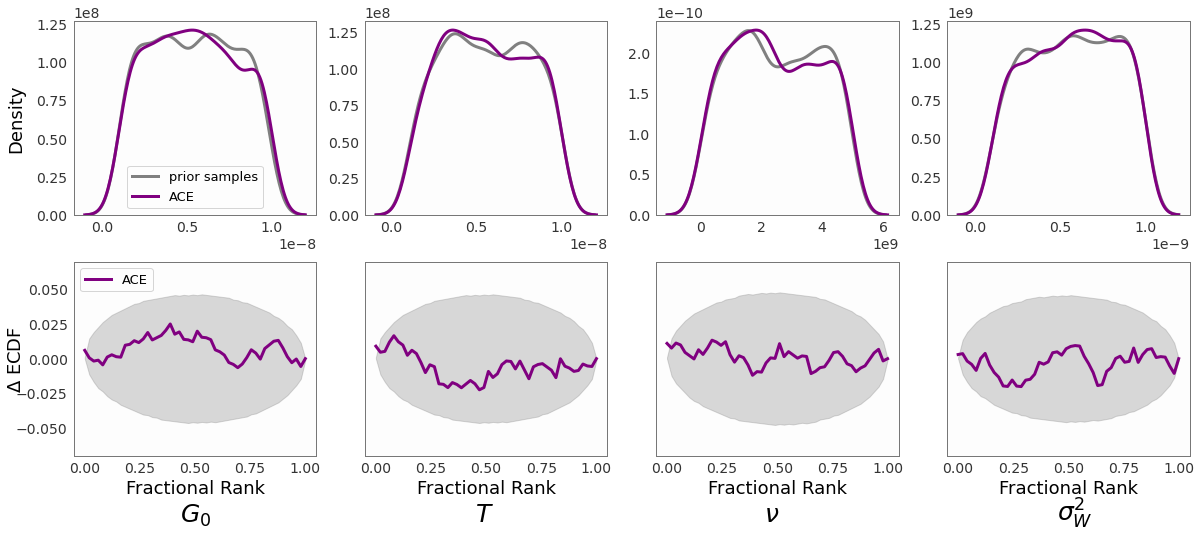

In [738]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))


sns.kdeplot(prior_samples_1, color="grey", linewidth=3, linestyle="solid", label="prior samples", ax=axs[0, 0])
sns.kdeplot(ace_posterior_samples_1, color="purple", linewidth=3, linestyle="solid", label="ACE", ax=axs[0, 0])
axs[0, 0].set_ylabel("Density", fontsize=18)
# axs[0, 0].set_xlabel("$x$", fontsize=18)
axs[0, 0].legend(fontsize=13, loc=8)
axs[0, 0].yaxis.set_label_coords(-0.2, 0.5)


sns.kdeplot(prior_samples_2, color="grey", linewidth=3, linestyle="solid", label="prior", ax=axs[0, 1])
sns.kdeplot(ace_posterior_samples_2, color="purple", linewidth=3, linestyle="solid", label="ACE", ax=axs[0, 1])
# axs[0, 1].set_xlabel("$x$", fontsize=18)
axs[0, 1].set_ylabel("")


sns.kdeplot(prior_samples_3, color="grey", linewidth=3, linestyle="solid", label="prior", ax=axs[0, 2])
sns.kdeplot(ace_posterior_samples_3, color="purple", linewidth=3, linestyle="solid", label="ACE", ax=axs[0, 2])
# axs[0, 2].set_xlim(-0.2, 1.2)
axs[0, 2].set_ylabel("")
# axs[0, 2].set_xlabel("$x$", fontsize=18)


sns.kdeplot(prior_samples_4, color="grey", linewidth=3, linestyle="solid", label="prior", ax=axs[0, 3])
sns.kdeplot(ace_posterior_samples_4, color="purple", linewidth=3, linestyle="solid", label="ACE", ax=axs[0, 3])
# axs[0, 3].set_xlabel("$x$", fontsize=18)
axs[0, 3].set_ylabel("")

# fig.suptitle("ECDF Difference vs Fractional Rank Statistic")
plot_sbc_ecdf_diff_no_pi(axs[1, 0], prior_samples[:, 0].unsqueeze(-1), ace_posterior_samples[:, 0, :], num_points=50)
axs[1, 0].set_ylabel(r'$\Delta$ ECDF', fontsize=18)
axs[1, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[1, 0].legend(fontsize=13, loc=2)

plot_sbc_ecdf_diff_no_pi(axs[1,1], prior_samples[:, 1].unsqueeze(-1), ace_posterior_samples[:, 1, :], num_points=50)
axs[1, 1].set_yticks([])
plot_sbc_ecdf_diff_no_pi(axs[1,2], prior_samples[:, 2].unsqueeze(-1), ace_posterior_samples[:, 2, :], num_points=50)
axs[1, 2].set_yticks([])
plot_sbc_ecdf_diff_no_pi(axs[1,3], prior_samples[:, 3].unsqueeze(-1), ace_posterior_samples[:, 3, :], num_points=50)
axs[1, 3].set_yticks([])

fig.text(0.21, 0.01, '$G_0$', ha='center', fontsize=25)
fig.text(0.41, 0.01, '$T$', ha='center', fontsize=25)
fig.text(0.61, 0.01, '$\\nu$', ha='center', fontsize=25)
fig.text(0.82, 0.011, '$\sigma^2_W$', ha='center', fontsize=25)
# plt.tight_layout()
plt.subplots_adjust(hspace=0.24)
plt.savefig("sbc.pdf")
plt.show()